In [1]:
%pip install scipy
%pip install ripser gudhi
%pip install scikit-tda
%pip install numpy
%pip install tqdm
%pip install networkx
%pip install persim
%pip install pot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Preprocessing

In [2]:
from src.preprocessing.preprocessing import *

import numpy as np
from scipy.io import loadmat
import re

def load_data_from_mat(mat_dir):
    mats = []
    X = []
    y = []

    for file in os.listdir(mat_dir):
        if file.endswith(".mat"):
            mats.append(file)
    mats.sort()

    pattern = r'_([a-zA-Z]+)\d+\.mat'
    for i in range(len(mats)):        
        mat = loadmat(mat_dir + mats[i])
        X.append(mat["dm"])
        class_name = re.search(pattern, mats[i])
        
        if class_name:
            y.append(class_name.group(1))
            print(f"added {class_name.group(1)}")
        
    X = np.stack(X)
    return X, np.array(y)

VR persistence diagram with Ripser

In [3]:
import os
from src.shape.shape import *
from tqdm.notebook import tqdm
# Load preprocessed data

data_path = "data/preprocessing/geodesic/"
shape_paths = []
for file in os.listdir(data_path):
    if file.endswith(".mat"):
        shape_paths.append(data_path + file)
shape_paths.sort()
print(f"Found {len(shape_paths)} shapes... {shape_paths[0], shape_paths[1]}, ...")

shapes = []
for f in tqdm(shape_paths, desc="Loading shapes"):
    shapes.append(load_from_mat(f))
    
print(f"Loaded {len(shapes)} shapes... {shapes[0], shapes[1]}, ...")


# Load Euclidean Preprocessed data
data_path = "data/preprocessing/euclidean/"
euclidean_shape_paths = []
for file in os.listdir(data_path):
    if file.endswith(".mat"):
        euclidean_shape_paths.append(data_path + file)

euclidean_shape_paths.sort()
print(f"Found {len(euclidean_shape_paths)} shapes... {euclidean_shape_paths[0], euclidean_shape_paths[1]}, ...")

euclidean_shapes = []
for f in tqdm(euclidean_shape_paths, desc="Loading shapes"):
    euclidean_shapes.append(load_from_mat(f))

Found 148 shapes... ('data/preprocessing/geodesic/pre_geodesic_cat0.mat', 'data/preprocessing/geodesic/pre_geodesic_cat1.mat'), ...


Loading shapes:   0%|          | 0/148 [00:00<?, ?it/s]

Loaded 148 shapes... (<src.shape.shape.Shape object at 0x15701dcd0>, <src.shape.shape.Shape object at 0x157031d50>), ...
Found 148 shapes... ('data/preprocessing/euclidean/pre_euclidean_cat0.mat', 'data/preprocessing/euclidean/pre_euclidean_cat1.mat'), ...


Loading shapes:   0%|          | 0/148 [00:00<?, ?it/s]

### Visualize

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

from mayavi import mlab

def show_shape(shape):
    x = shape.coordinates[:, 0]
    y = shape.coordinates[:, 1]
    z = shape.coordinates[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=z, cmap='viridis')
    plt.show()

def show_shape_interactive(shape):
    x = shape.coordinates[:, 0]
    y = shape.coordinates[:, 1]
    z = shape.coordinates[:, 2]

    mlab.figure(bgcolor=(0, 0, 0))  # You can choose a background color
    points = mlab.points3d(x, y, z, z, colormap='viridis', scale_mode='none', scale_factor=1.2)
    mlab.axes()
    mlab.show()




Visualize shapes

In [5]:
shape_euc_0 = euclidean_shapes[0]

show_shape_interactive(shape_euc_0)

shape_0 = shapes[0]

show_shape_interactive(shape_0)

In [6]:
# Load distance matrix and labels
import numpy as np
from scipy.io import loadmat
import re

def load_data_from_mat(mat_dir):
    mats = []
    X = []
    y = []

    for file in os.listdir(mat_dir):
        if file.endswith(".mat"):
            mats.append(file)
    mats.sort()

    pattern = r'_([a-zA-Z]+)\d+\.mat'
    for i in range(len(mats)):        
        mat = loadmat(mat_dir + mats[i])
        X.append(mat["dm"])
        class_name = re.search(pattern, mats[i])
        
        if class_name:
            y.append(class_name.group(1))
            print(f"added {class_name.group(1)}")
        
    X = np.stack(X)
    return X, np.array(y)

euclidean_dataset_dir = "data/preprocessing/euclidean/"
geodesic_dataset_dir = "data/preprocessing/geodesic/"

X_euclidean, y_euclidean = load_data_from_mat(euclidean_dataset_dir)
X_geodesic, y_geodesic = load_data_from_mat(geodesic_dataset_dir)

print(f"X_euclidean shape: {X_euclidean.shape}")
print(f"X_geodesic shape: {X_geodesic.shape}")

print(f"y_euclidean shape: {len(y_euclidean)}")
print(f"y_geodesic shape: {len(y_geodesic)}")

# save to csv
np.savetxt("data/cl_data/X_euclidean.csv", X_euclidean.reshape(X_euclidean.shape[0], -1), delimiter=",")
np.savetxt("data/cl_data/X_geodesic.csv", X_geodesic.reshape(X_geodesic.shape[0], -1), delimiter=",")
np.savetxt("data/cl_data/y_euclidean.csv", y_euclidean, delimiter=",", fmt="%s")
np.savetxt("data/cl_data/y_geodesic.csv", y_geodesic, delimiter=",", fmt="%s")


added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added centaur
added centaur
added centaur
added centaur
added centaur
added centaur
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added lioness
added lioness
added lion

In [7]:
from tqdm.notebook import tqdm
dDiam_matrix = np.zeros((len(shapes), len(shapes)))


tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing dDiam matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        dDiam_matrix[i,j] = dDiam(shapes[i], shapes[j])
        dDiam_matrix[j,i] = dDiam_matrix[i,j]
        tqdm_bar.update(1)



Computing dDiam matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

Found 12 classes
Shape: cat, mean_between_cluster_distance: 61.822856844469534, mean_within_cluster_distance: 4.398616746383848, ratio wcd/bcd: 0.07114871377506285,std_between_cluster_distance: 73.9989880393702, std_within_cluster_distance: 3.834312812811796
Shape: centaur, mean_between_cluster_distance: 72.82400917794567, mean_within_cluster_distance: 5.1068965340410175, ratio wcd/bcd: 0.07012655018157957,std_between_cluster_distance: 42.1015551527342, std_within_cluster_distance: 4.028495589989785
Shape: david, mean_between_cluster_distance: 61.48230069882469, mean_within_cluster_distance: 4.357772070097068, ratio wcd/bcd: 0.0708784808077355,std_between_cluster_distance: 73.89962733401063, std_within_cluster_distance: 3.5956558633832376
Shape: dog, mean_between_cluster_distance: 87.12972249736859, mean_within_cluster_distance: 9.498283663826037, ratio wcd/bcd: 0.109013128833423,std_between_cluster_distance: 78.34524409976228, std_within_cluster_distance: 7.244549558589696
Shape: gori

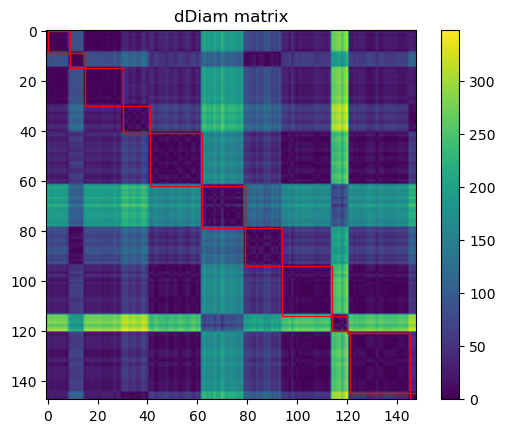

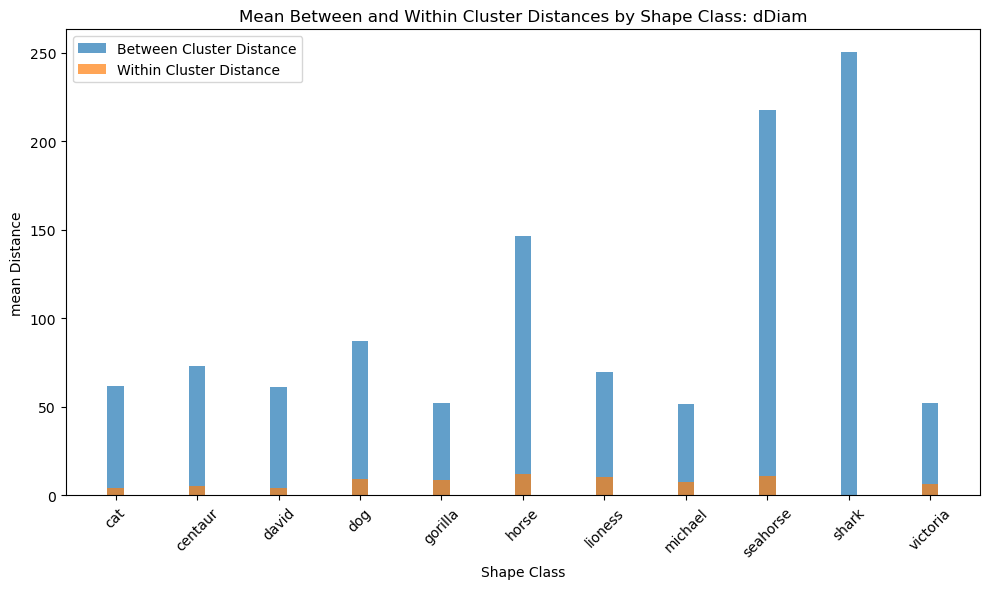

   shape_class    mean_BCD   mean_WCD  ratio_WCD_BCD    std_BCD    std_WCD
0          cat   61.822857   4.398617       0.071149  73.998988   3.834313
1      centaur   72.824009   5.106897       0.070127  42.101555   4.028496
2        david   61.482301   4.357772       0.070878  73.899627   3.595656
3          dog   87.129722   9.498284       0.109013  78.345244   7.244550
4      gorilla   52.306255   8.622510       0.164847  63.901358   6.291730
5        horse  146.799130  12.171149       0.082910  60.684028  11.060496
6      lioness   69.800733  10.590151       0.151720  44.137039   7.807225
7      michael   51.830546   7.499886       0.144700  66.433377   5.975688
8     seahorse  217.506964  10.842012       0.049847  76.880179   8.800632
9        shark  250.763648   0.000000       0.000000  78.767094   0.000000
10    victoria   52.192314   6.650508       0.127423  68.184258   4.921238


In [8]:
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt

y_df = pd.DataFrame({"y": y_geodesic})
num_classes = y_df['y'].nunique()
print(f"Found {num_classes} classes")

def plot_distance_matrix(distance_matrix, distance_name):
    plt.imshow(distance_matrix)

    start = 0
    curr=0
    shape_classes = []
    mean_between_cluster_distances = []
    mean_within_cluster_distances = []
    ratio_within_between_cluster_distances = []
    std_between_cluster_distances = []
    std_within_cluster_distances = []
    for i in range(len(y_df)):
        if y_df['y'][i] != y_df['y'][start]:
            box_x = start
            box_y = start
            box_width = i - start
            box_height = i - start
            box = Rectangle((box_x , box_y ), box_width, box_height, fill=False, color='red', linewidth=1)
            plt.gca().add_patch(box)
            
            
            between_cluster_distances = np.concatenate([distance_matrix[start:i, :i], distance_matrix[start:i, i:]], axis = 1)
            mean_between_cluster_distance = np.mean(between_cluster_distances)
            std_between_cluster_distance = np.std(between_cluster_distances)
            within_cluster_distances = distance_matrix[start:i, start:i]
            mean_within_cluster_distance = np.mean(within_cluster_distances)
            std_within_cluster_distance = np.std(within_cluster_distances)

            ratio_within_between_cluster_distance = mean_within_cluster_distance / mean_between_cluster_distance
            print(f"Shape: {y_df['y'][start]}, mean_between_cluster_distance: {mean_between_cluster_distance}, mean_within_cluster_distance: {mean_within_cluster_distance}, ratio wcd/bcd: {ratio_within_between_cluster_distance},std_between_cluster_distance: {std_between_cluster_distance}, std_within_cluster_distance: {std_within_cluster_distance}")
            
            shape_classes.append(y_df['y'][start])
            mean_between_cluster_distances.append(mean_between_cluster_distance)
            mean_within_cluster_distances.append(mean_within_cluster_distance)
            std_between_cluster_distances.append(std_between_cluster_distance)
            std_within_cluster_distances.append(std_within_cluster_distance)
            ratio_within_between_cluster_distances.append(ratio_within_between_cluster_distance)
            
            start = i

    box_x = start
    box_y = start
    box_width = len(y_df) - start
    box_height = len(y_df) - start
    box = Rectangle((box_x , box_y ), box_width, box_height, fill=False, color='red', linewidth=1)
    plt.gca().add_patch(box)

    plt.colorbar()
    plt.title(distance_name + " matrix")
    plt.savefig(distance_name + "_matrix.png")
    plt.show()

    np.savetxt("data/" +distance_name+"_heatmap.csv", distance_matrix, delimiter=",")


    distance_mean_df = pd.DataFrame({"shape_class": shape_classes, 
    "mean_BCD": mean_between_cluster_distances, 
    "mean_WCD": mean_within_cluster_distances,
    "ratio_WCD_BCD": ratio_within_between_cluster_distances,
    "std_BCD": std_between_cluster_distances,
    "std_WCD": std_within_cluster_distances})
    distance_mean_df.to_csv(f"data/_{distance_name}_mean_distances.csv")
    return distance_mean_df


def report_distance_matrix(distance_mean_df, distance_name):        
    plt.figure(figsize=(10, 6))
    plt.bar(distance_mean_df['shape_class'], distance_mean_df['mean_BCD'], 0.2,label='Between Cluster Distance', alpha=0.7,)
    plt.bar(distance_mean_df['shape_class'], distance_mean_df['mean_WCD'], 0.2, label='Within Cluster Distance', alpha=0.7)

    plt.xlabel('Shape Class')
    plt.ylabel('mean Distance')
    plt.title(f'Mean Between and Within Cluster Distances by Shape Class: {distance_name}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()
    print(distance_mean_df)


# plot dDiam matrix
import matplotlib.pyplot as plt
mean_df = plot_distance_matrix(dDiam_matrix, "dDiam")
report_distance_matrix(mean_df, "dDiam")

In [9]:
d_E_inf_matrix = np.zeros((len(shapes), len(shapes)))

tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing d_E_inf matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        d_E_inf_matrix[i,j] = d_E_inf(euclidean_shapes[i], euclidean_shapes[j])
        d_E_inf_matrix[j,i] = d_E_inf_matrix[i,j]
        tqdm_bar.update(1)



Computing d_E_inf matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

Shape: cat, mean_between_cluster_distance: 7.8144352658016905, mean_within_cluster_distance: 1.6557931311336564, ratio wcd/bcd: 0.21188903290041997,std_between_cluster_distance: 4.5354925483794055, std_within_cluster_distance: 0.8444495175302517
Shape: centaur, mean_between_cluster_distance: 10.197100267753944, mean_within_cluster_distance: 3.3842998610602484, ratio wcd/bcd: 0.3318884557566176,std_between_cluster_distance: 3.4790176555674486, std_within_cluster_distance: 1.7405867652683213
Shape: david, mean_between_cluster_distance: 7.631593795939609, mean_within_cluster_distance: 3.1156246609157985, ratio wcd/bcd: 0.40825347158459446,std_between_cluster_distance: 4.744425851820411, std_within_cluster_distance: 2.2388005295938425
Shape: dog, mean_between_cluster_distance: 7.766718817577315, mean_within_cluster_distance: 3.2931031865521896, ratio wcd/bcd: 0.42400185508188803,std_between_cluster_distance: 4.422064524042445, std_within_cluster_distance: 1.7591979912409523
Shape: gorilla,

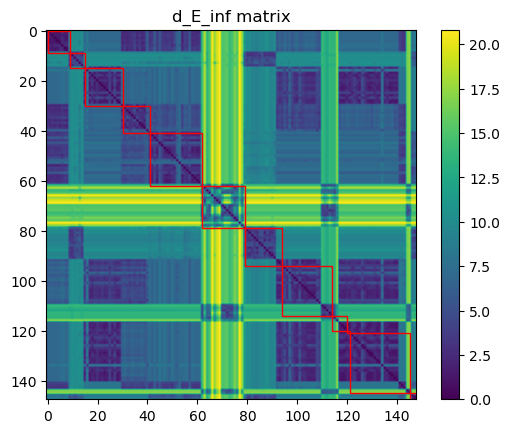

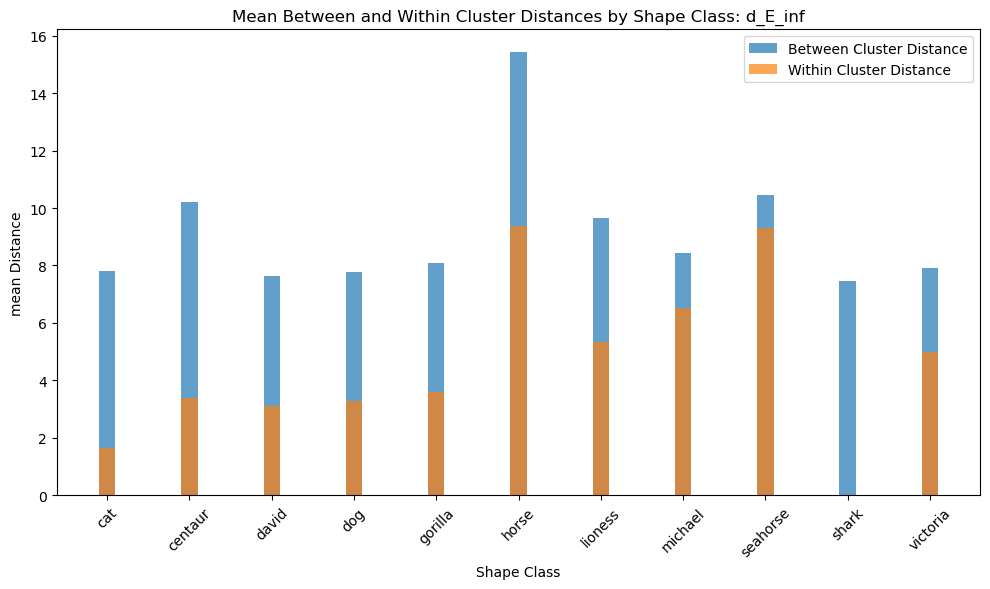

   shape_class   mean_BCD  mean_WCD  ratio_WCD_BCD   std_BCD   std_WCD
0          cat   7.814435  1.655793       0.211889  4.535493  0.844450
1      centaur  10.197100  3.384300       0.331888  3.479018  1.740587
2        david   7.631594  3.115625       0.408253  4.744426  2.238801
3          dog   7.766719  3.293103       0.424002  4.422065  1.759198
4      gorilla   8.077504  3.596717       0.445276  4.277952  1.890341
5        horse  15.445855  9.381159       0.607358  4.044840  4.937701
6      lioness   9.642138  5.326286       0.552397  3.858574  2.959300
7      michael   8.451643  6.522292       0.771719  4.854253  4.917207
8     seahorse  10.448392  9.299805       0.890070  5.313716  6.498402
9        shark   7.443842  0.000000       0.000000  4.847273  0.000000
10    victoria   7.911589  4.995565       0.631424  4.984160  4.379499


In [10]:
# plot distance matrix

mean_df = plot_distance_matrix(d_E_inf_matrix, "d_E_inf")
report_distance_matrix(mean_df, "d_E_inf")

In [11]:
d_G_1_matrix = np.zeros((len(shapes), len(shapes)))
d_G_inf_matrix = np.zeros((len(shapes), len(shapes)))

tqdm_bar = tqdm(total=len(shapes)**2 / 2, desc = "Computing d_G_1 and g_G_inf matrix")
for i in range(len(shapes)):
    for j in range(i+1, len(shapes)):
        d_G_1_matrix[i,j] = d_G_wasserstein(shapes[i], shapes[j], q=1)
        d_G_inf_matrix[i,j] = d_G_wasserstein(shapes[i], shapes[j], q=np.inf)
        d_G_1_matrix[j,i] = d_G_1_matrix[i,j]
        d_G_inf_matrix[j,i] = d_G_inf_matrix[i,j]
        tqdm_bar.update(1)




Computing d_G_1 and g_G_inf matrix:   0%|          | 0/10952.0 [00:00<?, ?it/s]

Shape: cat, mean_between_cluster_distance: 566.7503564848198, mean_within_cluster_distance: 45.372119397292906, ratio wcd/bcd: 0.0800566225995981,std_between_cluster_distance: 683.8096330606642, std_within_cluster_distance: 18.164717477038845
Shape: centaur, mean_between_cluster_distance: 850.3132239521087, mean_within_cluster_distance: 70.63685213194952, ratio wcd/bcd: 0.08307156720865949,std_between_cluster_distance: 350.58043249708044, std_within_cluster_distance: 37.941412103535384
Shape: david, mean_between_cluster_distance: 679.3496177593867, mean_within_cluster_distance: 37.21905388302273, ratio wcd/bcd: 0.05478630282560201,std_between_cluster_distance: 722.9625546241658, std_within_cluster_distance: 12.410242304621779
Shape: dog, mean_between_cluster_distance: 610.7304995057038, mean_within_cluster_distance: 45.01317449049516, ratio wcd/bcd: 0.07370382603607759,std_between_cluster_distance: 708.298950340666, std_within_cluster_distance: 18.245942931468715
Shape: gorilla, mean_b

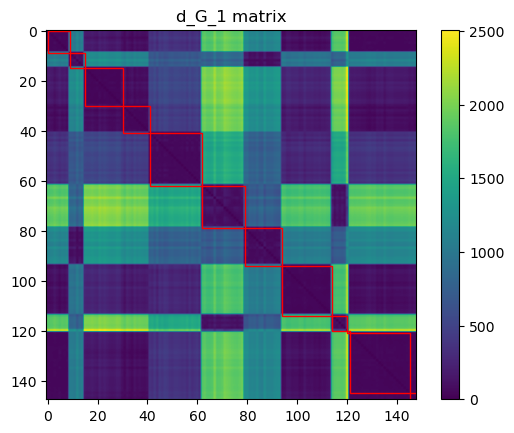

Shape: cat, mean_between_cluster_distance: 12.111256460527757, mean_within_cluster_distance: 2.869636888857241, ratio wcd/bcd: 0.23693965181975796,std_between_cluster_distance: 6.465022473504999, std_within_cluster_distance: 1.5146568134096132
Shape: centaur, mean_between_cluster_distance: 14.955774817380819, mean_within_cluster_distance: 3.6140521897210016, ratio wcd/bcd: 0.24164927821198132,std_between_cluster_distance: 4.889199734023331, std_within_cluster_distance: 1.9950260703860376
Shape: david, mean_between_cluster_distance: 10.844753411009505, mean_within_cluster_distance: 1.7511374876234267, ratio wcd/bcd: 0.16147324159954493,std_between_cluster_distance: 7.319104564877785, std_within_cluster_distance: 0.5516517122534081
Shape: dog, mean_between_cluster_distance: 10.186854359851715, mean_within_cluster_distance: 2.494620047324945, ratio wcd/bcd: 0.2448861993312387,std_between_cluster_distance: 7.055963679118478, std_within_cluster_distance: 1.0902857012617193
Shape: gorilla, m

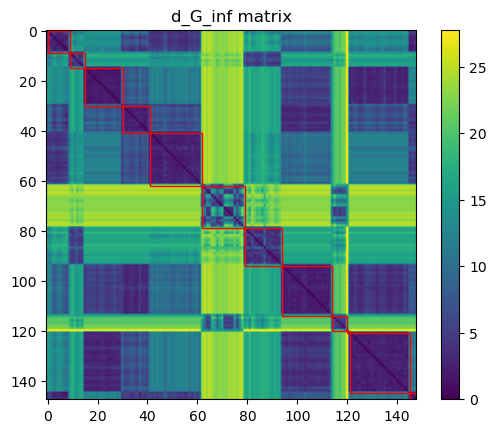

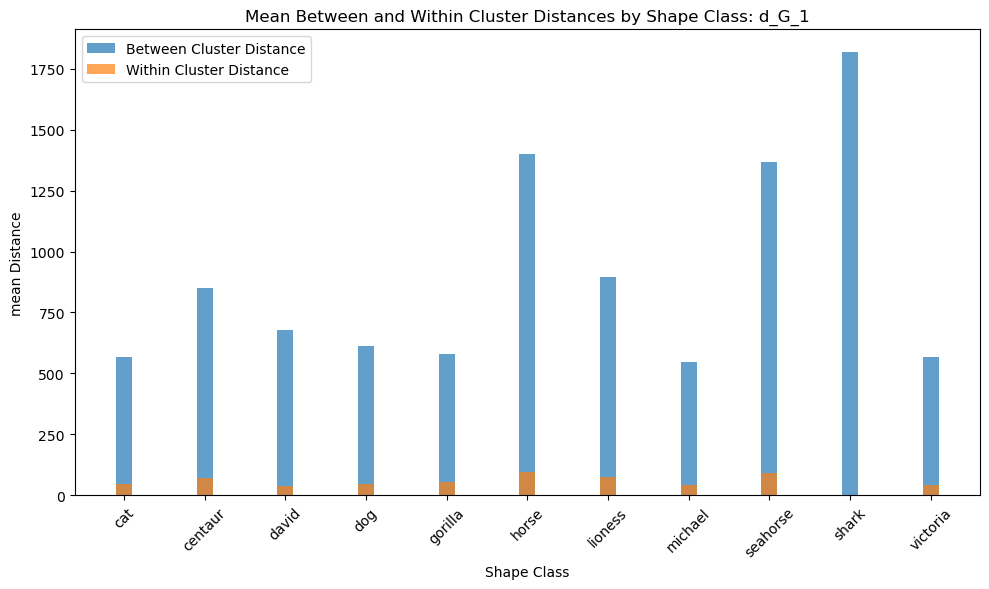

   shape_class     mean_BCD   mean_WCD  ratio_WCD_BCD     std_BCD    std_WCD
0          cat   566.750356  45.372119       0.080057  683.809633  18.164717
1      centaur   850.313224  70.636852       0.083072  350.580432  37.941412
2        david   679.349618  37.219054       0.054786  722.962555  12.410242
3          dog   610.730500  45.013174       0.073704  708.298950  18.245943
4      gorilla   577.779434  56.643112       0.098036  469.553579  18.725199
5        horse  1398.464241  95.779098       0.068489  689.826861  41.312080
6      lioness   896.100393  75.969819       0.084778  387.805678  31.503729
7      michael   546.156006  42.855117       0.078467  637.491882  13.318411
8     seahorse  1366.715512  91.117158       0.066669  672.373000  48.214645
9        shark  1820.122015   0.000000       0.000000  720.361957   0.000000
10    victoria   565.783318  42.496885       0.075112  684.604954  11.226492


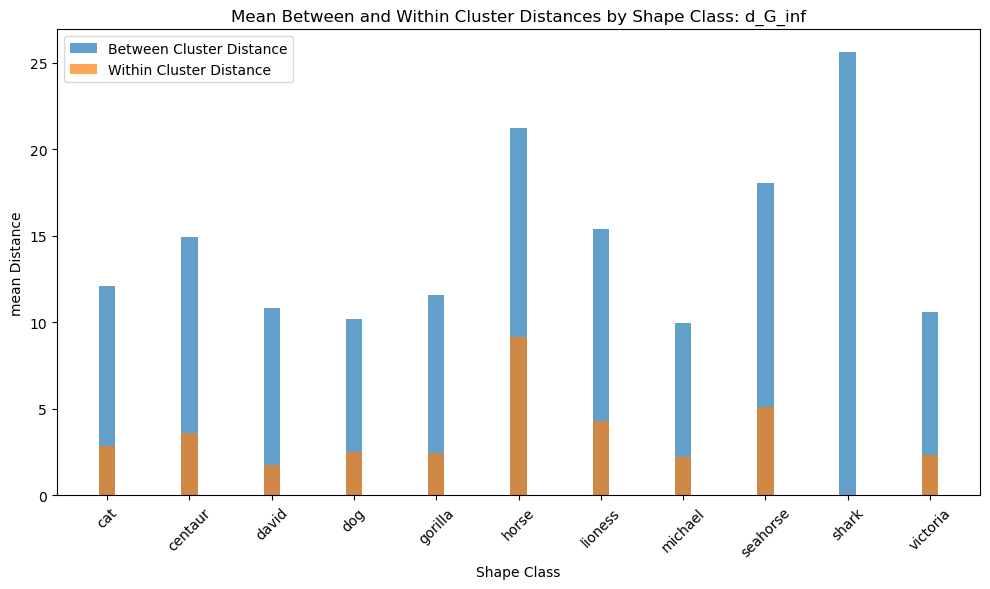

   shape_class   mean_BCD  mean_WCD  ratio_WCD_BCD   std_BCD   std_WCD
0          cat  12.111256  2.869637       0.236940  6.465022  1.514657
1      centaur  14.955775  3.614052       0.241649  4.889200  1.995026
2        david  10.844753  1.751137       0.161473  7.319105  0.551652
3          dog  10.186854  2.494620       0.244886  7.055964  1.090286
4      gorilla  11.596338  2.452731       0.211509  6.526558  0.800742
5        horse  21.198143  9.174478       0.432796  5.600018  5.805043
6      lioness  15.411778  4.314708       0.279962  4.907910  2.180268
7      michael   9.946858  2.214861       0.222669  7.374079  0.706180
8     seahorse  18.033907  5.126485       0.284269  4.701304  2.935538
9        shark  25.643905  0.000000       0.000000  5.113552  0.000000
10    victoria  10.571282  2.349956       0.222296  7.448227  0.687054


In [12]:
mean_df_d_G_1 = plot_distance_matrix(d_G_1_matrix, "d_G_1")
mean_df_d_G_inf = plot_distance_matrix(d_G_inf_matrix, "d_G_inf")

report_distance_matrix(mean_df_d_G_1, "d_G_1")
report_distance_matrix(mean_df_d_G_inf, "d_G_inf")

In [13]:
# compute the mean diameter of a class
import numpy as np
def mean_diameter_class(shapes, class_label, y_labels):
    indices = np.where(y_labels == class_label)[0]
    # print(indices)
    # shapes_to_see = shapes[*indices]
    diams = []
    for i in indices:
        diams.append(np.max(shapes[i].dm))
    return np.mean(diams)

    

In [14]:
class_to_see = "horse"
print(f"mean diam of class {class_to_see} is {mean_diameter_class(shapes, class_to_see, y_geodesic)}")
class_to_see = "seahorse"
print(f"mean diam of class {class_to_see} is {mean_diameter_class(shapes, class_to_see, y_geodesic)}")

mean diam of class horse is 401.6945316484627
mean diam of class seahorse is 480.8483895309619


['cat' 'centaur' 'david' 'dog' 'gorilla' 'horse' 'lioness' 'michael'
 'seahorse' 'shark' 'victoria' 'wolf']
[208.7751279228795, 293.4053348952545, 209.27881001570037, 177.90623780902027, 240.61829224659886, 401.6945316484627, 287.2515410927312, 235.0952528210158, 480.8483895309619, 515.0062059688406, 230.55796708610998, 182.12753309780112]


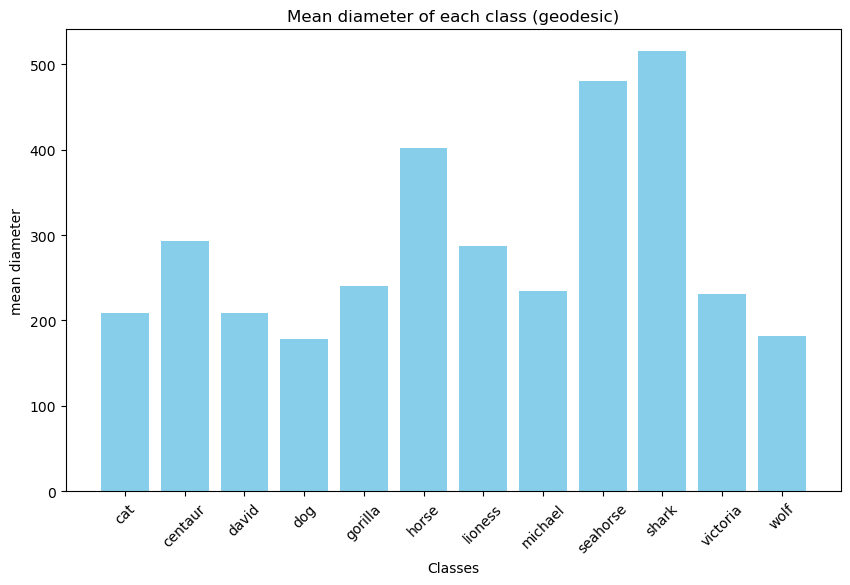

In [31]:
unique_classes = np.unique(y_geodesic)

mean_diams = []
for c in unique_classes:
    mean_diams.append(mean_diameter_class(shapes, c, y_geodesic))


print(unique_classes)
print(mean_diams)

from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(unique_classes, mean_diams, color = "skyblue")
plt.xlabel("Classes")
plt.ylabel("mean diameter")
plt.title("Mean diameter of each class (geodesic)")
plt.xticks(rotation=45)
plt.show()


['cat' 'centaur' 'david' 'dog' 'gorilla' 'horse' 'lioness' 'michael'
 'seahorse' 'shark' 'victoria' 'wolf']
[170.48450634184, 228.55484968354494, 157.099454195049, 154.09741760302953, 152.92834099483758, 305.967574021222, 232.78493913366648, 174.05910131447186, 392.80160996023073, 484.26495788464644, 169.50739396878814, 165.9713325950717]


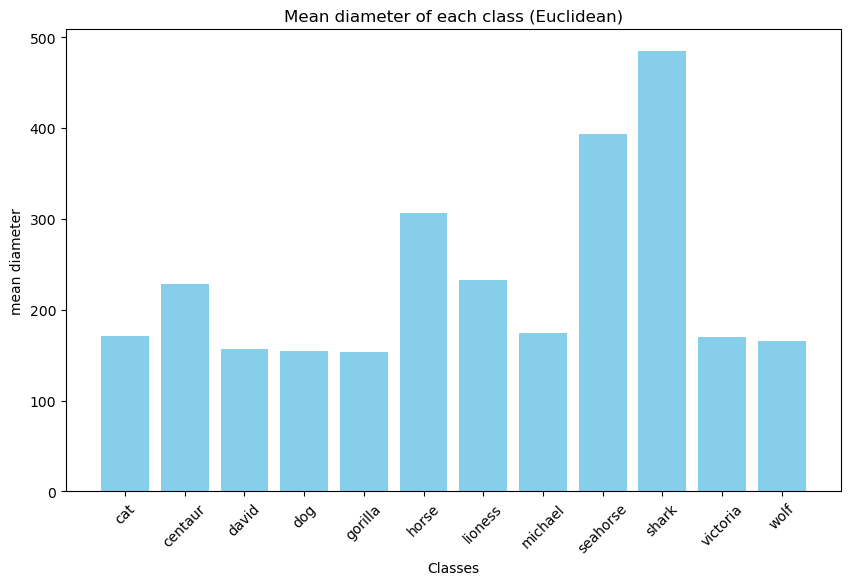

In [30]:
unique_classes = np.unique(y_geodesic)

mean_diams = []
for c in unique_classes:
    mean_diams.append(mean_diameter_class(euclidean_shapes, c, y_euclidean))


print(unique_classes)
print(mean_diams)

from matplotlib import pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(unique_classes, mean_diams, color = "skyblue")
plt.xlabel("Classes")
plt.ylabel("mean diameter")
plt.title("Mean diameter of each class (Euclidean)")
plt.xticks(rotation=45)
plt.show()


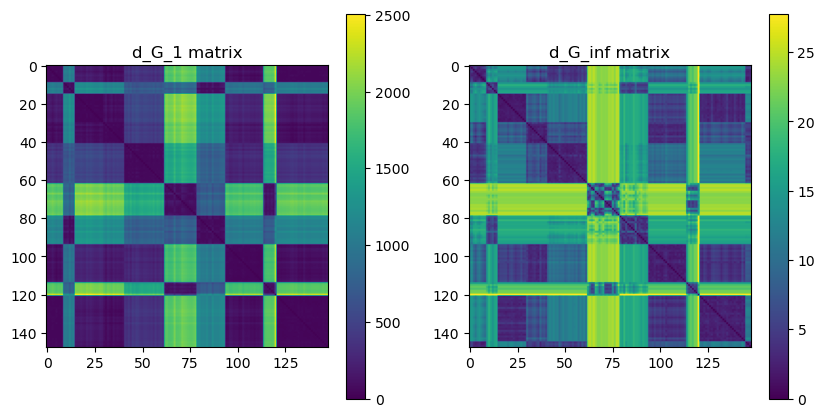

In [16]:
plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(d_G_1_matrix)
plt.colorbar()
plt.title("d_G_1 matrix")
plt.subplot(1,2,2)
plt.imshow(d_G_inf_matrix)
plt.colorbar()
plt.title("d_G_inf matrix")
plt.savefig("d_G_matrix.png")
plt.show()


### Evaluate the distance matrix using classification

In [17]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

class Classifier:
    def __init__(self, distance_matrix, X_train, y_train):
        self.distance_matrix = distance_matrix
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        y_pred = []
        for i in range(len(X_test)):
            distances = self.distance_matrix[i, :]
            min_index = np.argmin(distances)
            y_pred.append(self.y_train[min_index])
        return y_pred


def split_dataset(X, y, testset_portion = 0.1, k_fold= False, random_state=123):
    if k_fold:
        skf = StratifiedKFold(n_splits=10, shuffle=True)
        return skf.split(X, y)
    else:
        return train_test_split(X, y, test_size=testset_portion, random_state=random_state, stratify=y)

def evaluate(y_test, y_pred):
    for i in range(len(y_test)):
        if y_test[i] != y_pred[i]:
            print(f"y_test: {y_test[i]}, y_pred: {y_pred[i]}")

    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, cm

def evaluate_distance_matrix(distance_matrix, X, y, k_fold = False, test_portion = 0.1, num_splits = 10):
    if k_fold:
        skf = StratifiedKFold(n_splits=num_splits, shuffle=True)
        splits = skf.split(X, y)
        accuracies = []
        cms = []
        
        for train_index, test_index in splits:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            classifier = Classifier(distance_matrix, X_train, y_train)
            y_pred = classifier.predict(X_test)
            
            accuracy, cm = evaluate(y_test, y_pred)
            accuracies.append(accuracy)
            cms.append(cm)
        return np.mean(accuracies) , accuracies, cms
    else:
        accuracies = []
        cms = []
        for i in range(num_splits):
            X_train, X_test, y_train, y_test = split_dataset(X, y, testset_portion=test_portion)
            classifier = Classifier(distance_matrix, X_train, y_train)
            y_pred = classifier.predict(X_test)

            accuracy, cm = evaluate(y_test, y_pred)
            accuracies.append(accuracy)
            cms.append(cm)
        return np.mean(accuracies) , accuracies, cms


In [18]:
# remove shark from dataset
X_euclidean, y_euclidean = load_data_from_mat(euclidean_dataset_dir)
X_geodesic, y_geodesic = load_data_from_mat(geodesic_dataset_dir)

y_geodesic = np.array(y_geodesic)
# find shark
ind = np.where(y_geodesic == "shark")

# remove shark
X_geodesic = np.delete(X_geodesic, ind, axis=0)
y_geodesic = np.delete(y_geodesic, ind, axis=0)

X_euclidean = np.delete(X_euclidean, ind, axis=0)
y_euclidean = np.delete(y_euclidean, ind, axis=0)


added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added centaur
added centaur
added centaur
added centaur
added centaur
added centaur
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added lioness
added lioness
added lion

y_test: centaur, y_pred: cat
y_test: david, y_pred: cat
y_test: dog, y_pred: cat
y_test: dog, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: horse, y_pred: cat
y_test: lioness, y_pred: centaur
y_test: lioness, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: victoria, y_pred: centaur
y_test: victoria, y_pred: david
y_test: victoria, y_pred: david
y_test: centaur, y_pred: cat
y_test: david, y_pred: cat
y_test: dog, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: horse, y_pred: cat
y_test: lioness, y_pred: centaur
y_test: lioness, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: victoria, y_pred: centaur
y_test: victoria, y_pred: david
y_test: victoria, y_pred: david
y_test: centaur, y_pred: cat
y_test: david, y_pred: cat
y_test: dog, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: horse, 

/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


y_test: david, y_pred: cat
y_test: david, y_pred: cat
y_test: dog, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: horse, y_pred: cat
y_test: horse, y_pred: cat
y_test: lioness, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: seahorse, y_pred: centaur
y_test: victoria, y_pred: centaur
y_test: victoria, y_pred: centaur
y_test: david, y_pred: cat
y_test: david, y_pred: cat
y_test: dog, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: horse, y_pred: cat
y_test: horse, y_pred: cat
y_test: lioness, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: michael, y_pred: centaur
y_test: seahorse, y_pred: centaur
y_test: victoria, y_pred: centaur
y_test: victoria, y_pred: centaur
y_test: centaur, y_pred: cat
y_test: david, y_pred: cat
y_test: david, y_pred: cat
y_test: dog, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: gorilla, y_pred: cat
y_test: horse, y_pred: cat
y_test: lioness, y_pred

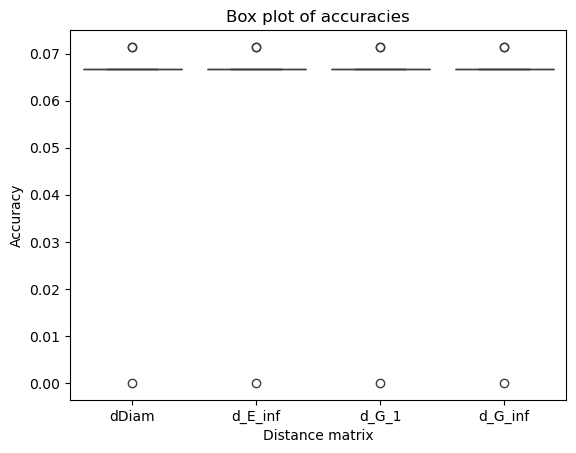

mean_acc_dDiam: 0.06095238095238096
mean_acc_d_E_inf: 0.06095238095238096
mean_acc_d_G_1: 0.06095238095238096
mean_acc_d_G_inf: 0.06095238095238096


<Figure size 640x480 with 0 Axes>

In [19]:
mean_acc_dDiam, accuracies_dDiam, cms_dDiam = evaluate_distance_matrix(dDiam_matrix, X_geodesic, y_geodesic, k_fold=True, num_splits=10)
mean_acc_d_E_inf, accuracies_d_E_inf, cms_d_E_inf = evaluate_distance_matrix(d_E_inf_matrix, X_euclidean, y_euclidean, k_fold=True, num_splits=10)
mean_acc_d_G_1, accuracies_d_G_1, cms_d_G_1 = evaluate_distance_matrix(d_G_1_matrix, X_geodesic, y_geodesic, k_fold=True, num_splits=10)
mean_acc_d_G_inf, accuracies_d_G_inf, cms_d_G_inf = evaluate_distance_matrix(d_G_inf_matrix, X_geodesic, y_geodesic, k_fold=True, num_splits=10)

# draw box plot.
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    "dDiam": accuracies_dDiam,
    "d_E_inf": accuracies_d_E_inf,
    "d_G_1": accuracies_d_G_1,
    "d_G_inf": accuracies_d_G_inf
}
df = pd.DataFrame(data)
sns.boxplot(data=df)
plt.title("Box plot of accuracies")
plt.xlabel("Distance matrix")
plt.ylabel("Accuracy")
plt.show()
plt.savefig("boxplot.png")

print(f"mean_acc_dDiam: {mean_acc_dDiam}")
print(f"mean_acc_d_E_inf: {mean_acc_d_E_inf}")
print(f"mean_acc_d_G_1: {mean_acc_d_G_1}")
print(f"mean_acc_d_G_inf: {mean_acc_d_G_inf}")

### Dendrogram

added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added cat
added centaur
added centaur
added centaur
added centaur
added centaur
added centaur
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added david
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added dog
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added gorilla
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added horse
added lioness
added lioness
added lion

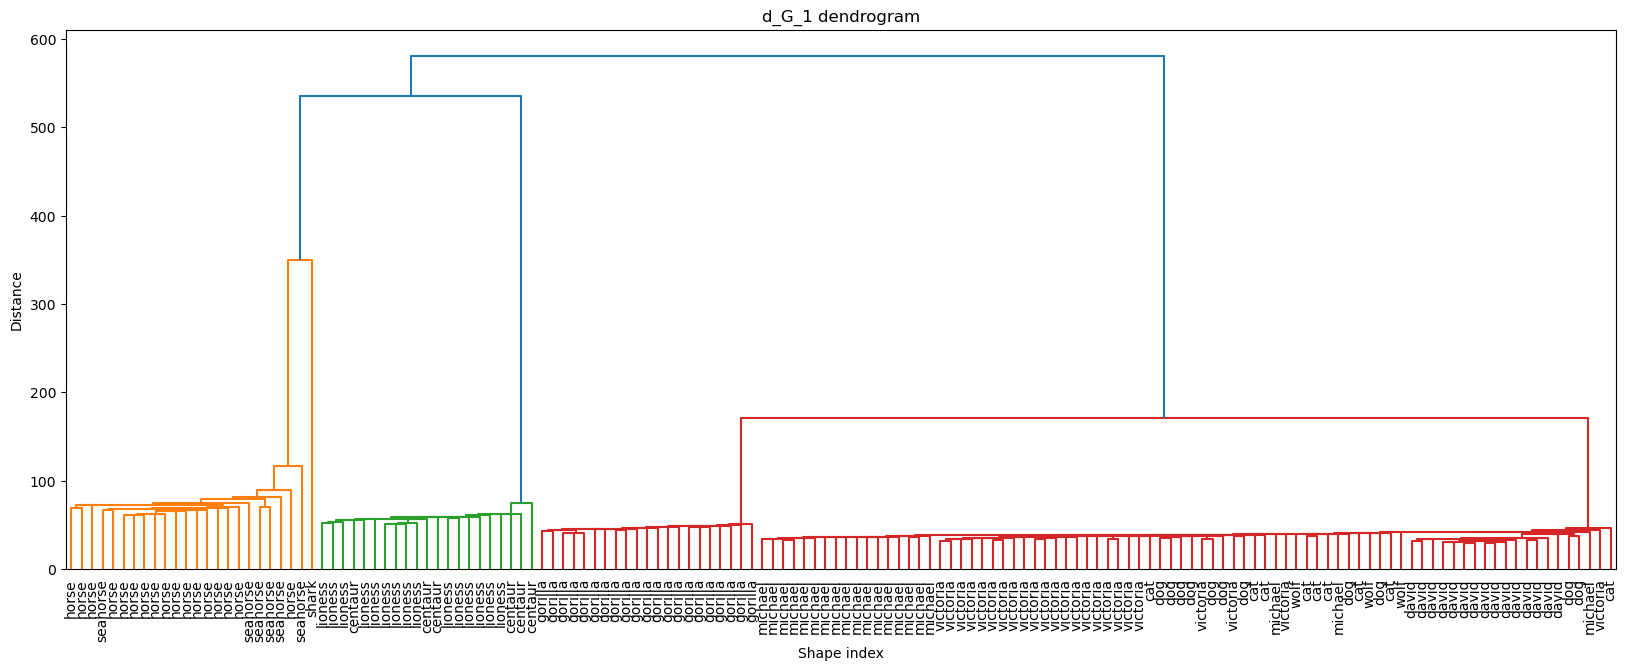

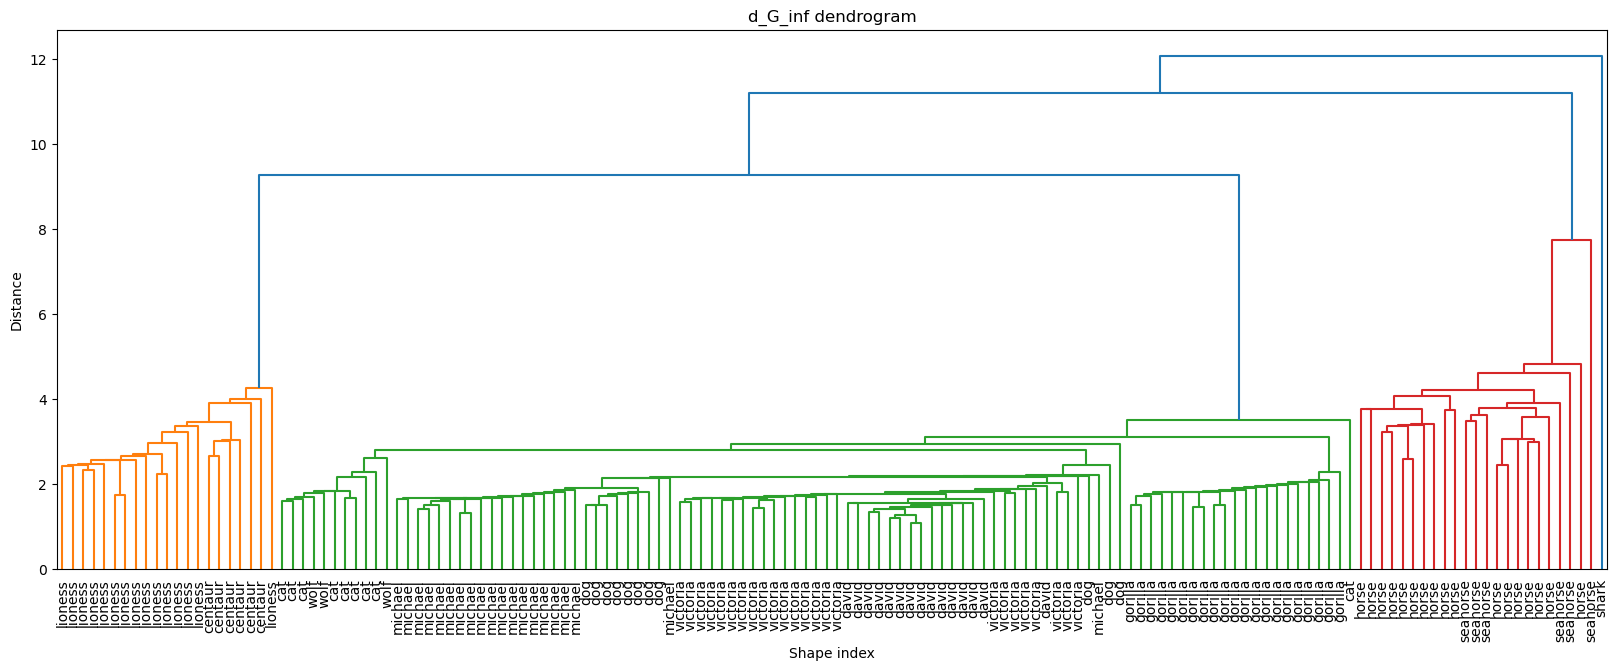

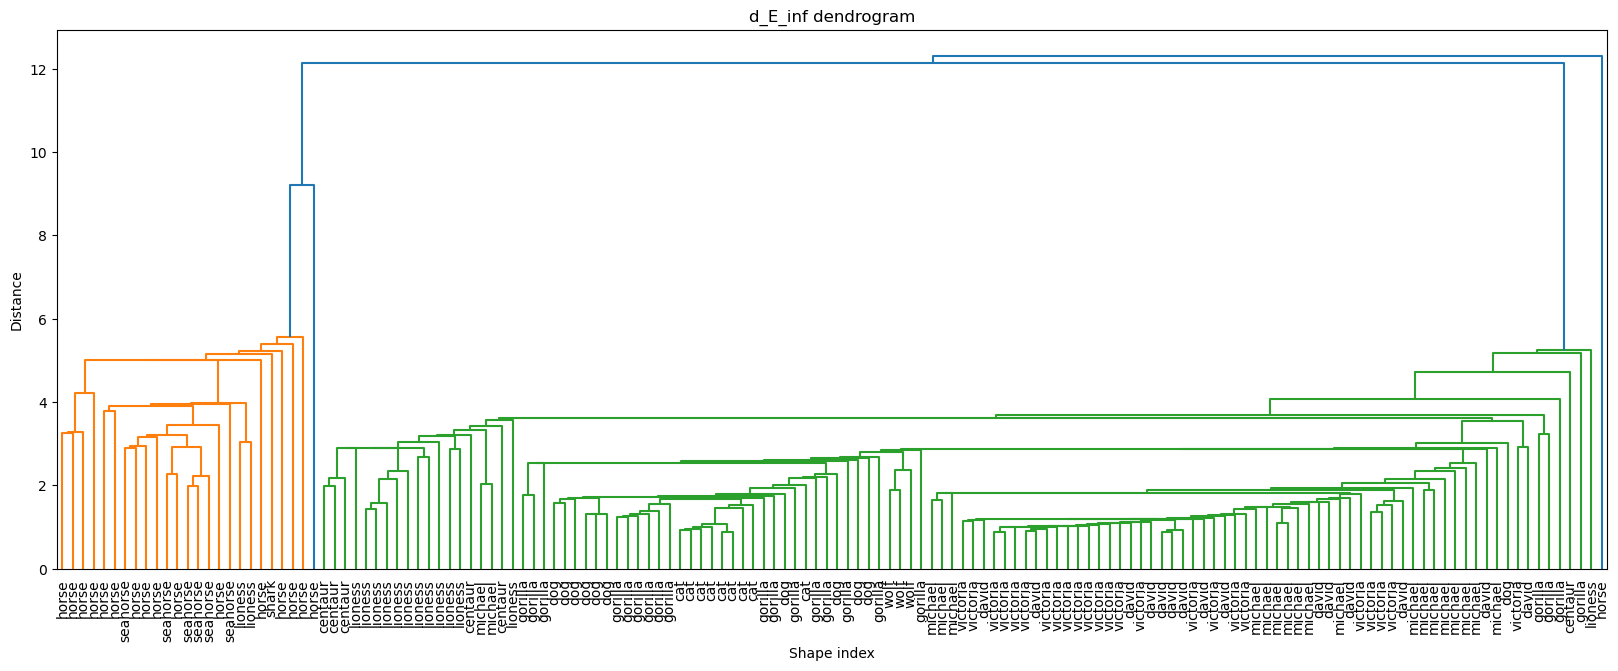

In [20]:
from scipy.cluster.hierarchy import single, dendrogram, complete
from scipy.spatial.distance import squareform

X_geodesic, y_geodesic = load_data_from_mat(geodesic_dataset_dir)
X_euclidean, y_euclidean = load_data_from_mat(euclidean_dataset_dir)

converted_d_G_1_matrix = squareform(d_G_1_matrix, checks= False)
converted_d_G_inf_matrix = squareform(d_G_inf_matrix, checks= False)
converted_d_E_inf_matrix = squareform(d_E_inf_matrix, checks= False)

linked_d_G_1 = single(converted_d_G_1_matrix)
linked_d_G_inf = single(converted_d_G_inf_matrix)
linked_d_E_inf = single(converted_d_E_inf_matrix)

plt.figure(0, figsize=(20, 7))
dendrogram(linked_d_G_1, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_1 dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_1_dendrogram.png")
plt.show()

plt.figure(1, figsize=(20, 7))
dendrogram(linked_d_G_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_inf_dendrogram.png")
plt.show()

plt.figure(2, figsize=(20, 7))
dendrogram(linked_d_E_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels = y_euclidean, leaf_font_size=10)
plt.title("d_E_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_E_inf_dendrogram.png")
plt.show()


### Complete Linkage

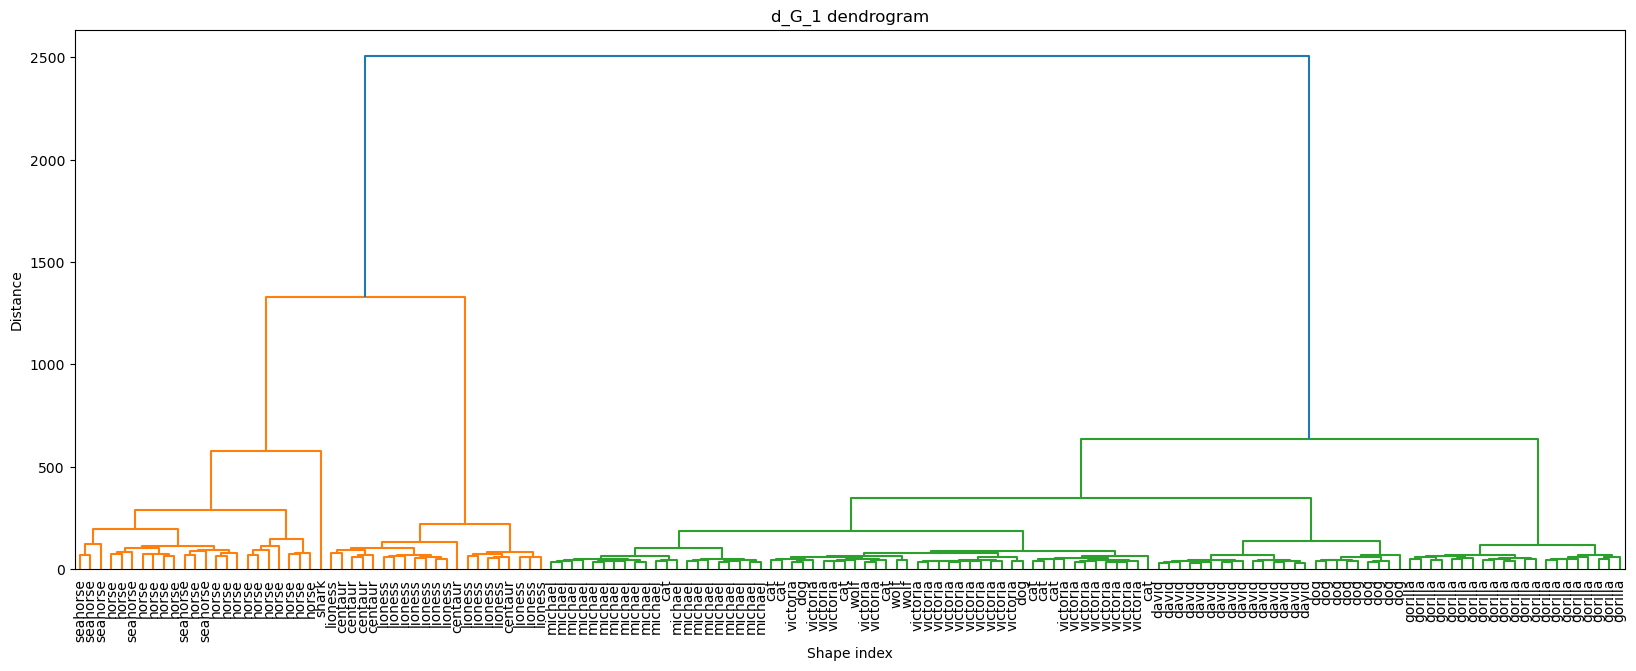

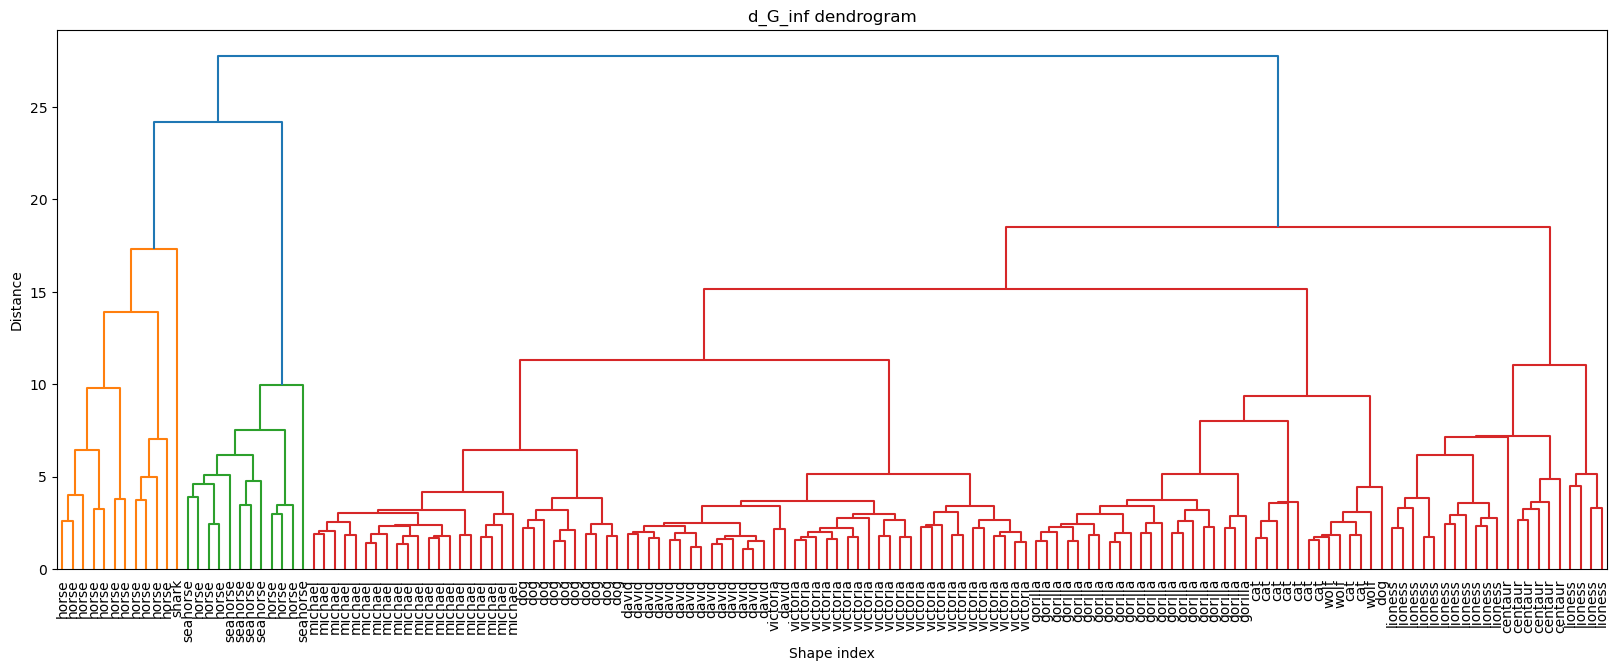

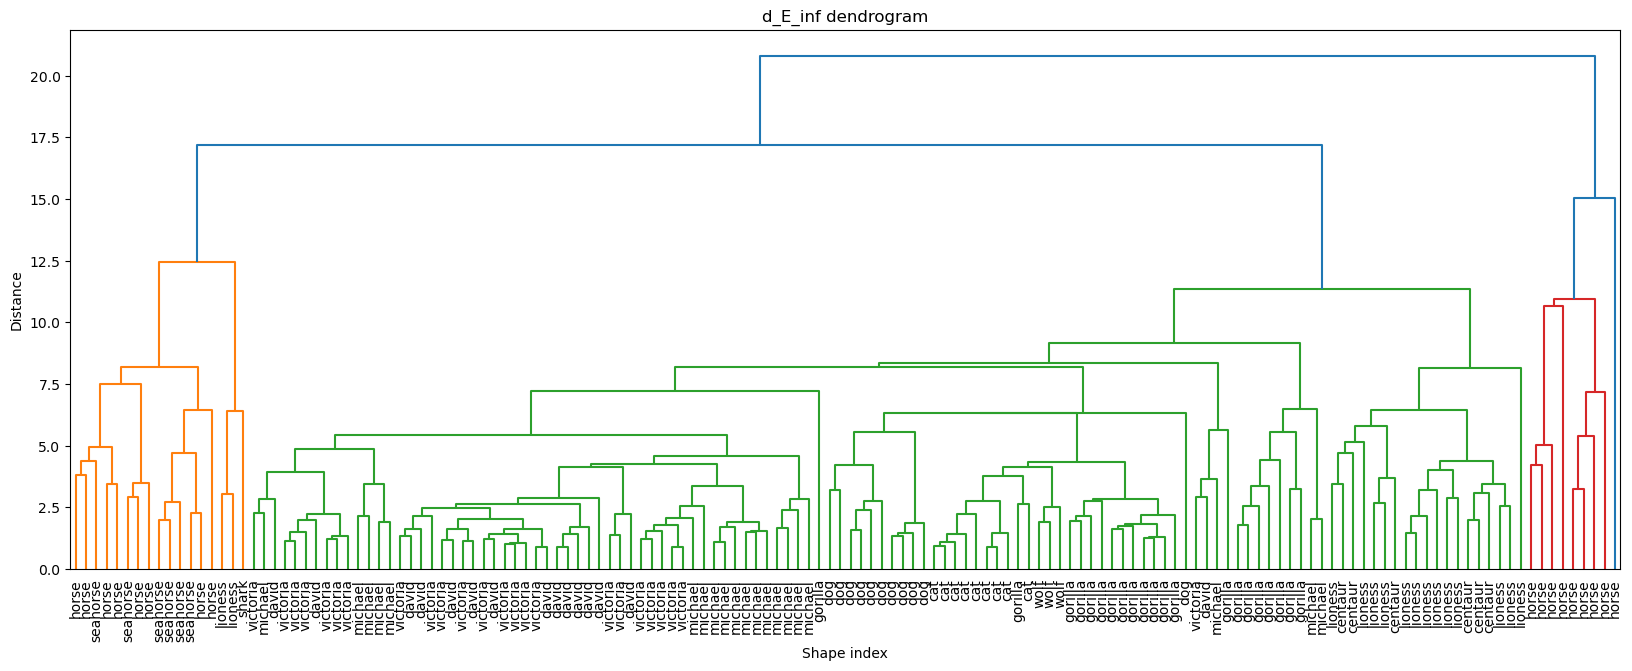

In [21]:
from scipy.cluster.hierarchy import single, dendrogram, complete
from scipy.spatial.distance import squareform

linked_d_G_1 = complete(converted_d_G_1_matrix)
linked_d_G_inf = complete(converted_d_G_inf_matrix)
linked_d_E_inf = complete(converted_d_E_inf_matrix)

plt.figure(0, figsize=(20, 7))
dendrogram(linked_d_G_1, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_1 dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_1_dendrogram.png")
plt.show()

plt.figure(1, figsize=(20, 7))
dendrogram(linked_d_G_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic, leaf_font_size=10)
plt.title("d_G_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_G_inf_dendrogram.png")
plt.show()

plt.figure(2, figsize=(20, 7))
dendrogram(linked_d_E_inf, orientation='top', distance_sort='descending', show_leaf_counts=False, labels = y_euclidean, leaf_font_size=10)
plt.title("d_E_inf dendrogram")
plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("d_E_inf_dendrogram.png")
plt.show()

## Multidimensional scaling Plot

/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `n

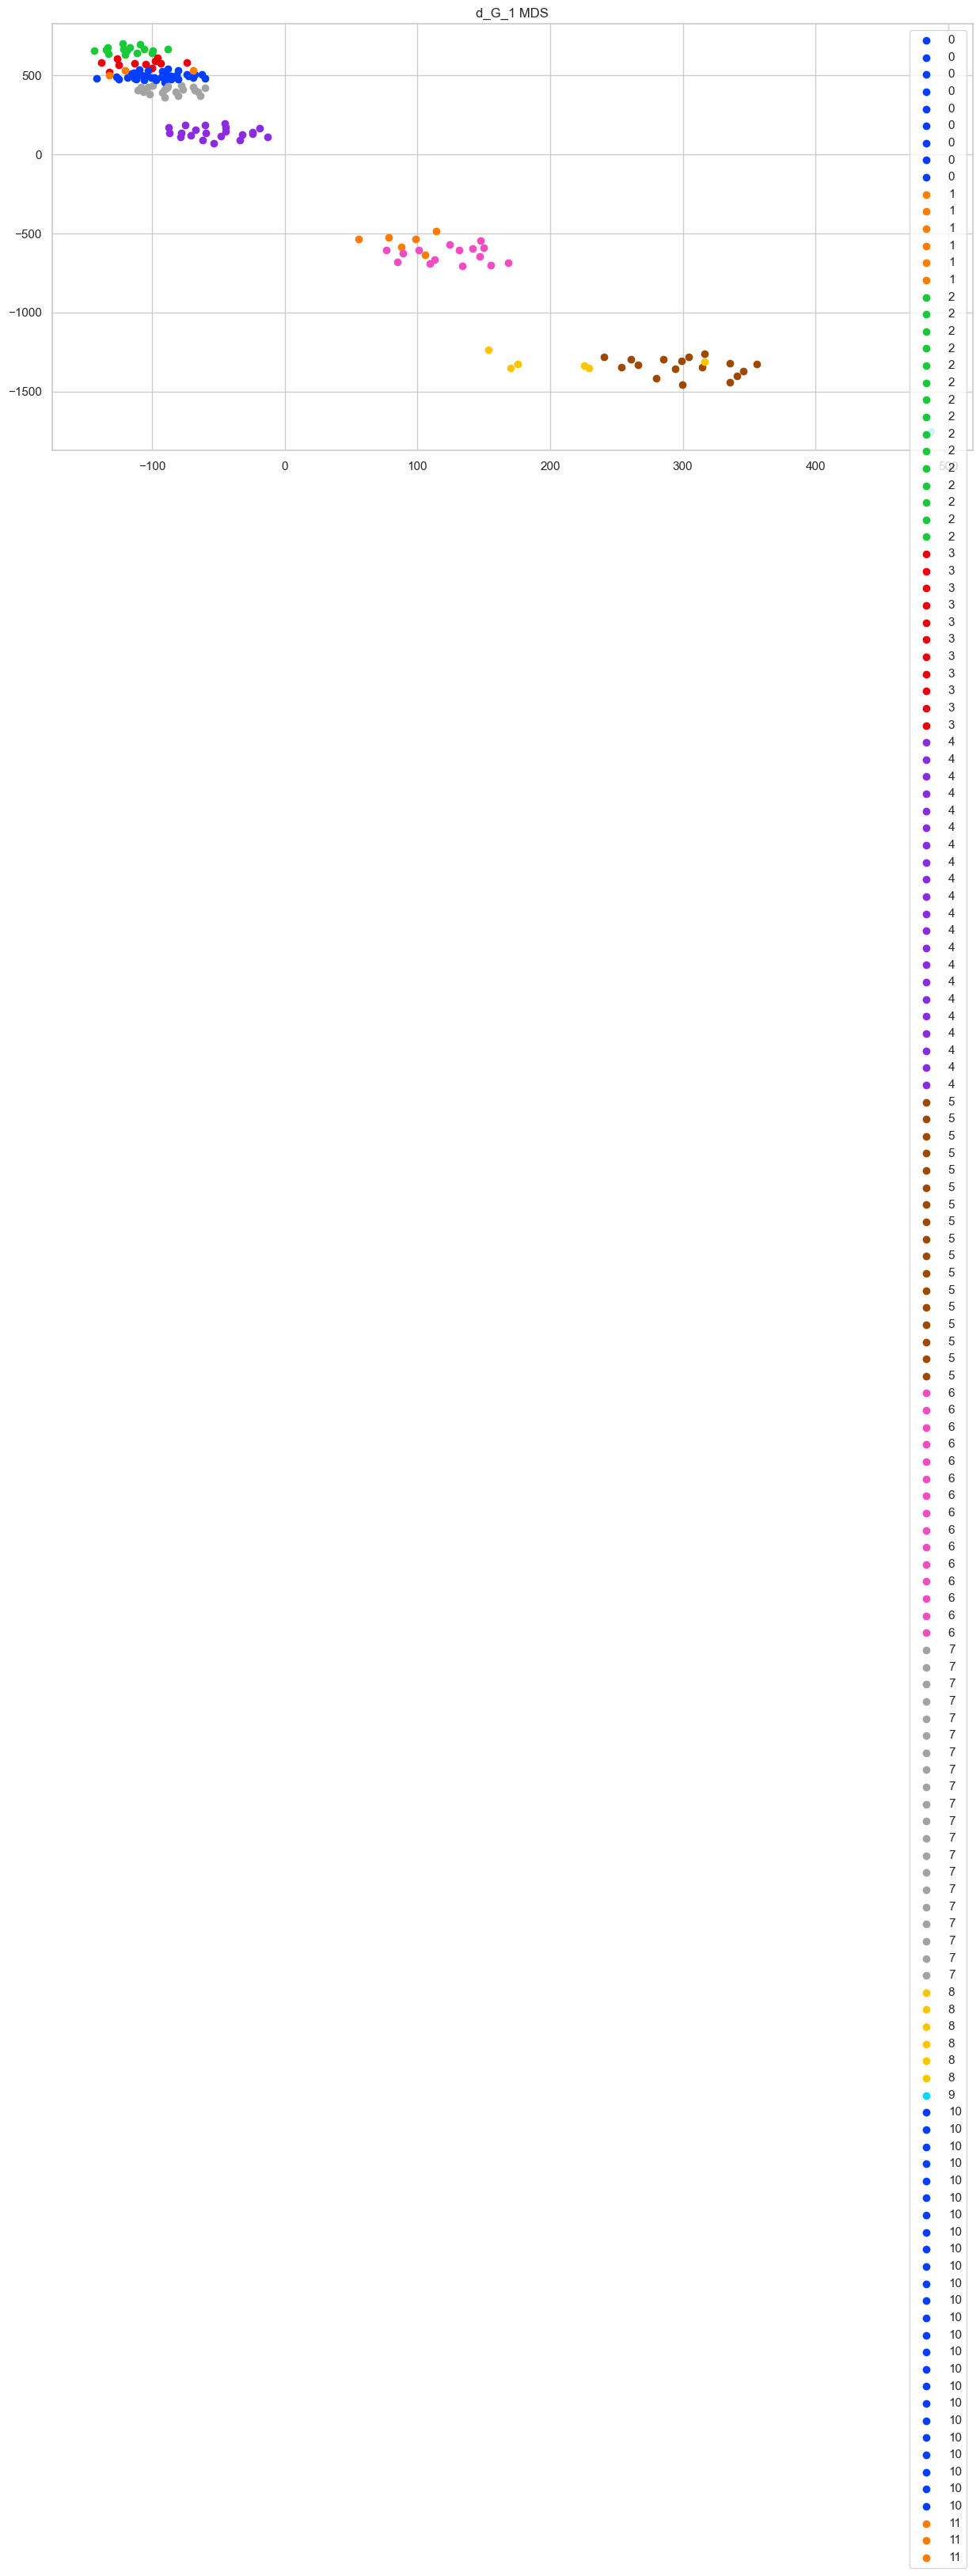

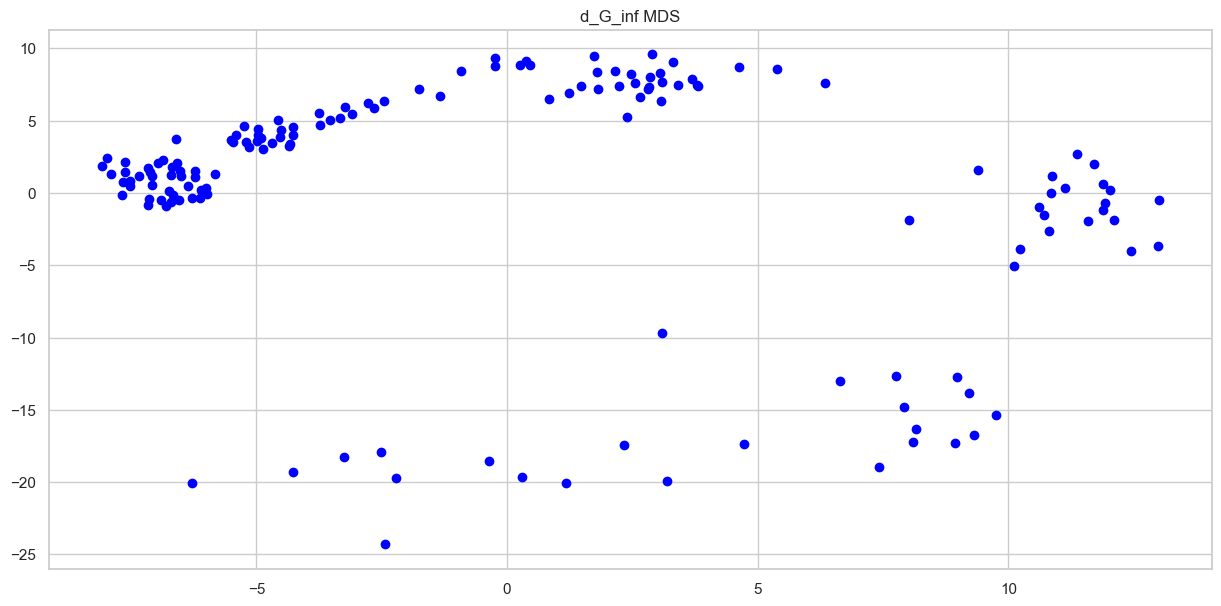

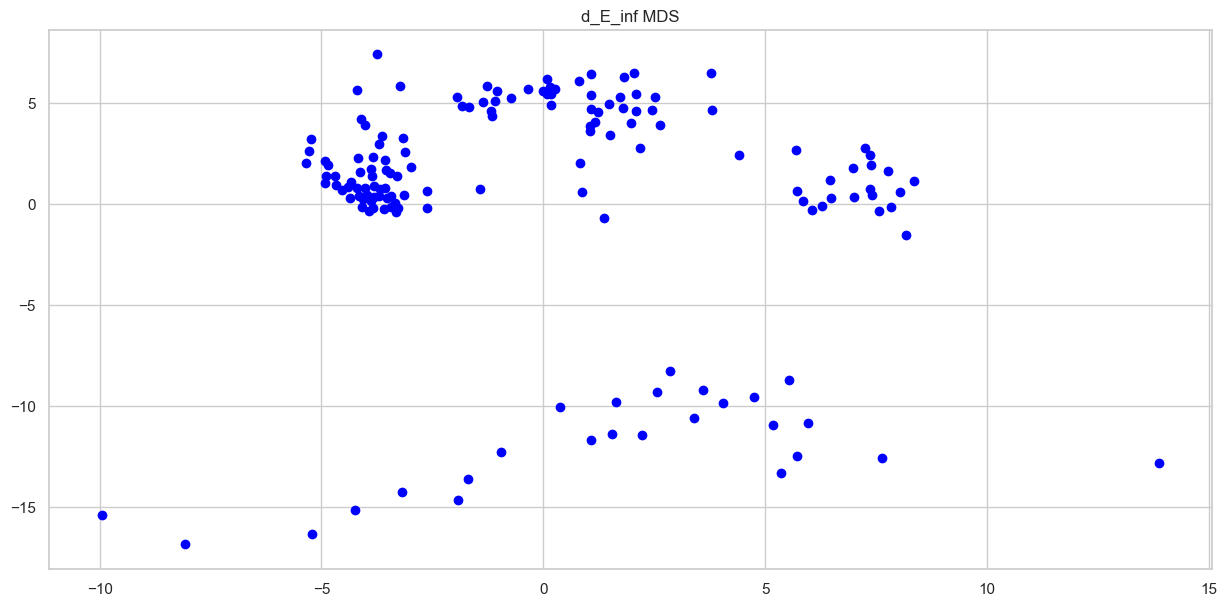

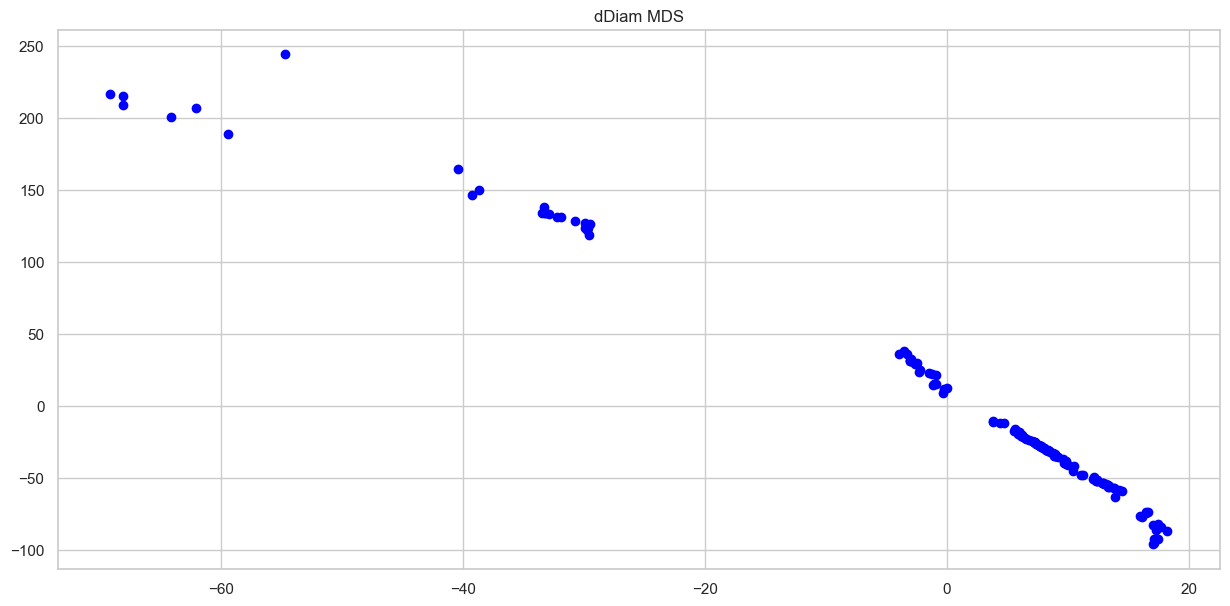

In [51]:
from sklearn.manifold import MDS

mds_d_G_1 = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
mds_d_G_inf = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
mds_d_E_inf = MDS(n_components=2, dissimilarity="precomputed", random_state=0)
mds_d_Diam = MDS(n_components=2, dissimilarity="precomputed", random_state=0)

mds_result_d_G_1 = mds_d_G_1.fit_transform(d_G_1_matrix, )
mds_result_d_G_inf = mds_d_G_inf.fit_transform(d_G_inf_matrix)
mds_result_d_E_inf = mds_d_E_inf.fit_transform(d_E_inf_matrix)
mds_result_d_Diam = mds_d_Diam.fit_transform(dDiam_matrix)

colors = sns.color_palette("bright", len(np.unique(y_geodesic)))

plt.figure(0, figsize=(15, 7))
for label in np.unique(y_geodesic):
    indices = np.where(y_geodesic == label)[0]
    plt.scatter(mds_result_d_G_1[indices,0], mds_result_d_G_1[indices,1], label = label, marker = 'o', )
# for i in range(len(mds_result_d_G_1)):
    # plt.scatter(mds_result_d_G_1[i,0], mds_result_d_G_1[i,1], label = y_geodesic_encoded[i], marker = 'o', color=colors[y_geodesic_encoded[i]])
plt.title("d_G_1 MDS")
plt.legend()
plt.show()

plt.figure(1, figsize=(15, 7))
plt.scatter(mds_result_d_G_inf[:,0], mds_result_d_G_inf[:,1], c='blue', marker = 'o')
plt.title("d_G_inf MDS")
plt.show()

plt.figure(2, figsize=(15, 7))
plt.scatter(mds_result_d_E_inf[:,0], mds_result_d_E_inf[:,1], c='blue', marker = 'o')
plt.title("d_E_inf MDS")
plt.show()

plt.figure(3, figsize=(15, 7))
plt.scatter(mds_result_d_Diam[:,0], mds_result_d_Diam[:,1], c='blue', marker = 'o')
plt.title("dDiam MDS")
plt.show()



### Baselines for classification: Logistic regression, SVM, Random Forest on the distance matrix

Using the same train and test set, we will compare the performance of the baseline models. And compare the classfication using dDiam and other dissimilarity measures.

TODO: use PCA before Logistic regression, SVM, RF on the distance matrix due to the high dimensionality of the distance matrix and the small sample size. 

1. Logistic regression

X_euclidean shape: (148, 40000)
X_geodesic shape: (148, 40000)
y_euclidean shape: 148
y_geodesic shape: 148


/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Euclidean accuracy: 0.3333333333333333
Geodesic accuracy: 0.43333333333333335


/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


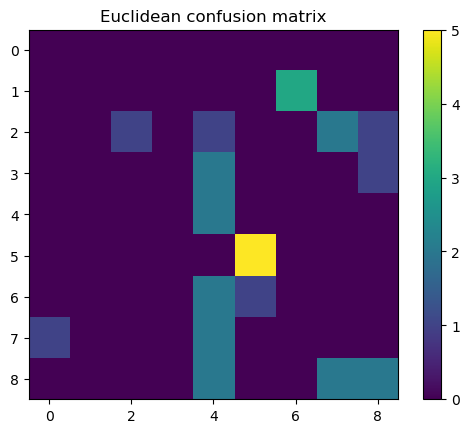

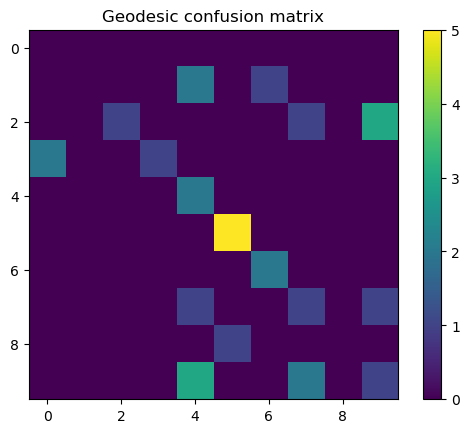

              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         0
     centaur       0.00      0.00      0.00         3
       david       1.00      0.20      0.33         5
         dog       0.00      0.00      0.00         3
     gorilla       0.18      1.00      0.31         2
       horse       0.83      1.00      0.91         5
     lioness       0.00      0.00      0.00         3
     michael       0.00      0.00      0.00         3
    victoria       0.50      0.33      0.40         6

    accuracy                           0.33        30
   macro avg       0.28      0.28      0.22        30
weighted avg       0.42      0.33      0.31        30

              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         0
     centaur       0.00      0.00      0.00         3
       david       1.00      0.20      0.33         5
         dog       1.00      0.33      0.50         3
     gorilla       0.25 

/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_euclidean = np.loadtxt("data/cl_data/X_euclidean.csv", delimiter=",")
X_geodesic = np.loadtxt("data/cl_data/X_geodesic.csv", delimiter=",")
y_euclidean = np.loadtxt("data/cl_data/y_euclidean.csv", delimiter=",", dtype=str)
y_geodesic = np.loadtxt("data/cl_data/y_geodesic.csv", delimiter=",", dtype=str)

print(f"X_euclidean shape: {X_euclidean.shape}")
print(f"X_geodesic shape: {X_geodesic.shape}")

print(f"y_euclidean shape: {len(y_euclidean)}")
print(f"y_geodesic shape: {len(y_geodesic)}")

X_euclidean_train, X_euclidean_test, y_euclidean_train, y_euclidean_test = train_test_split(X_euclidean, y_euclidean, test_size=0.2, random_state=42)
X_geodesic_train, X_geodesic_test, y_geodesic_train, y_geodesic_test = train_test_split(X_geodesic, y_geodesic, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_euclidean_train = scaler.fit_transform(X_euclidean_train)
X_euclidean_test = scaler.transform(X_euclidean_test)

X_geodesic_train = scaler.fit_transform(X_geodesic_train)
X_geodesic_test = scaler.transform(X_geodesic_test)

clf_euclidean = LogisticRegression(random_state=0).fit(X_euclidean_train, y_euclidean_train)
clf_geodesic = LogisticRegression(random_state=0).fit(X_geodesic_train, y_geodesic_train)

y_euclidean_pred = clf_euclidean.predict(X_euclidean_test)
y_geodesic_pred = clf_geodesic.predict(X_geodesic_test)

print(f"Euclidean accuracy: {accuracy_score(y_euclidean_test, y_euclidean_pred)}")
print(f"Geodesic accuracy: {accuracy_score(y_geodesic_test, y_geodesic_pred)}")

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm_euclidean = confusion_matrix(y_euclidean_test, y_euclidean_pred)
cm_geodesic = confusion_matrix(y_geodesic_test, y_geodesic_pred)

plt.figure(0)
plt.imshow(cm_euclidean)
plt.colorbar()
plt.title("Euclidean confusion matrix")
plt.savefig("euclidean_confusion_matrix.png")
plt.show()

plt.figure(1)
plt.imshow(cm_geodesic)
plt.colorbar()
plt.title("Geodesic confusion matrix")
plt.savefig("geodesic_confusion_matrix.png")
plt.show()

print(classification_report(y_euclidean_test, y_euclidean_pred))
print(classification_report(y_geodesic_test, y_geodesic_pred))

2. SVM

Euclidean accuracy: 0.26666666666666666
Geodesic accuracy: 0.26666666666666666


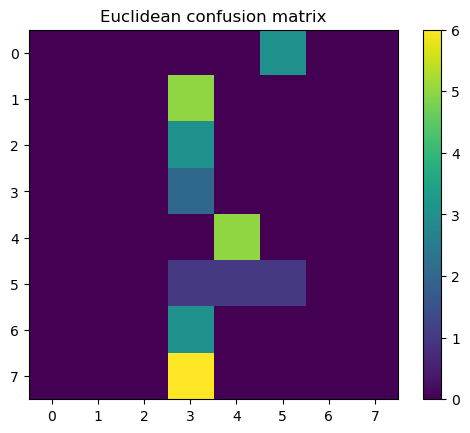

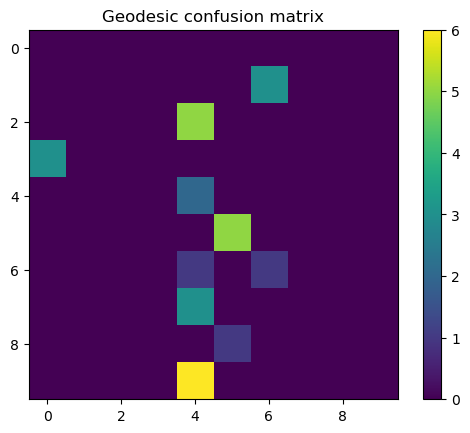

              precision    recall  f1-score   support

     centaur       0.00      0.00      0.00         3
       david       0.00      0.00      0.00         5
         dog       0.00      0.00      0.00         3
     gorilla       0.10      1.00      0.18         2
       horse       0.83      1.00      0.91         5
     lioness       0.25      0.33      0.29         3
     michael       0.00      0.00      0.00         3
    victoria       0.00      0.00      0.00         6

    accuracy                           0.27        30
   macro avg       0.15      0.29      0.17        30
weighted avg       0.17      0.27      0.19        30

              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         0
     centaur       0.00      0.00      0.00         3
       david       0.00      0.00      0.00         5
         dog       0.00      0.00      0.00         3
     gorilla       0.12      1.00      0.21         2
       horse       0.83 

/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [24]:
from sklearn.svm import SVC

clf_euclidean = SVC(random_state=0).fit(X_euclidean_train, y_euclidean_train)
clf_geodesic = SVC(random_state=0).fit(X_geodesic_train, y_geodesic_train)

y_euclidean_pred = clf_euclidean.predict(X_euclidean_test)
y_geodesic_pred = clf_geodesic.predict(X_geodesic_test)

print(f"Euclidean accuracy: {accuracy_score(y_euclidean_test, y_euclidean_pred)}")
print(f"Geodesic accuracy: {accuracy_score(y_geodesic_test, y_geodesic_pred)}")

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm_euclidean = confusion_matrix(y_euclidean_test, y_euclidean_pred)
cm_geodesic = confusion_matrix(y_geodesic_test, y_geodesic_pred)

plt.figure(0)
plt.imshow(cm_euclidean)
plt.colorbar()
plt.title("Euclidean confusion matrix")
plt.savefig("euclidean_confusion_matrix.png")
plt.show()

plt.figure(1)
plt.imshow(cm_geodesic)
plt.colorbar()
plt.title("Geodesic confusion matrix")
plt.savefig("geodesic_confusion_matrix.png")
plt.show()

print(classification_report(y_euclidean_test, y_euclidean_pred))
print(classification_report(y_geodesic_test, y_geodesic_pred))

3. Random Forest

Euclidean accuracy: 0.36666666666666664
Geodesic accuracy: 0.26666666666666666


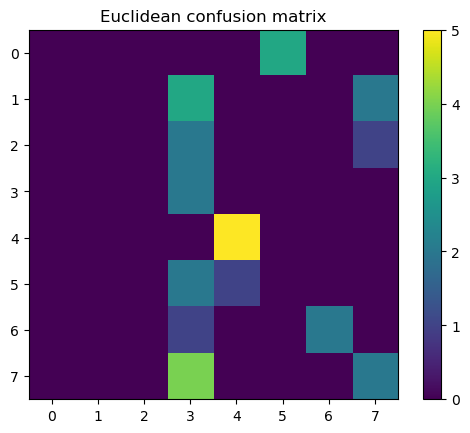

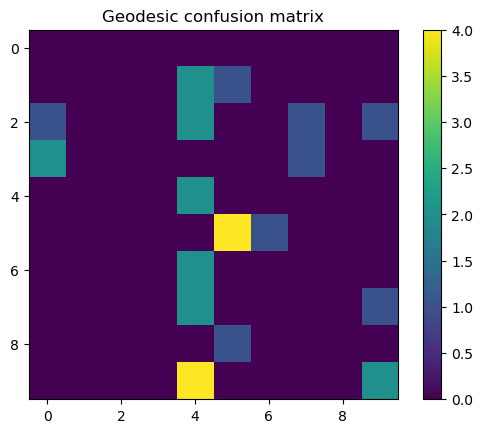

              precision    recall  f1-score   support

     centaur       0.00      0.00      0.00         3
       david       0.00      0.00      0.00         5
         dog       0.00      0.00      0.00         3
     gorilla       0.14      1.00      0.25         2
       horse       0.83      1.00      0.91         5
     lioness       0.00      0.00      0.00         3
     michael       1.00      0.67      0.80         3
    victoria       0.40      0.33      0.36         6

    accuracy                           0.37        30
   macro avg       0.30      0.38      0.29        30
weighted avg       0.33      0.37      0.32        30

              precision    recall  f1-score   support

         cat       0.00      0.00      0.00         0
     centaur       0.00      0.00      0.00         3
       david       0.00      0.00      0.00         5
         dog       0.00      0.00      0.00         3
     gorilla       0.14      1.00      0.25         2
       horse       0.67 

/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [25]:
from sklearn.ensemble import RandomForestClassifier

clf_euclidean = RandomForestClassifier(random_state=0).fit(X_euclidean_train, y_euclidean_train)
clf_geodesic = RandomForestClassifier(random_state=0).fit(X_geodesic_train, y_geodesic_train)

y_euclidean_pred = clf_euclidean.predict(X_euclidean_test)
y_geodesic_pred = clf_geodesic.predict(X_geodesic_test)

print(f"Euclidean accuracy: {accuracy_score(y_euclidean_test, y_euclidean_pred)}")
print(f"Geodesic accuracy: {accuracy_score(y_geodesic_test, y_geodesic_pred)}")

cm_euclidean = confusion_matrix(y_euclidean_test, y_euclidean_pred)
cm_geodesic = confusion_matrix(y_geodesic_test, y_geodesic_pred)

plt.figure(0)
plt.imshow(cm_euclidean)
plt.colorbar()
plt.title("Euclidean confusion matrix")
plt.savefig("euclidean_confusion_matrix.png")
plt.show()

plt.figure(1)
plt.imshow(cm_geodesic)
plt.colorbar()
plt.title("Geodesic confusion matrix")
plt.savefig("geodesic_confusion_matrix.png")
plt.show()

print(classification_report(y_euclidean_test, y_euclidean_pred))
print(classification_report(y_geodesic_test, y_geodesic_pred))

### Classification using dDiam

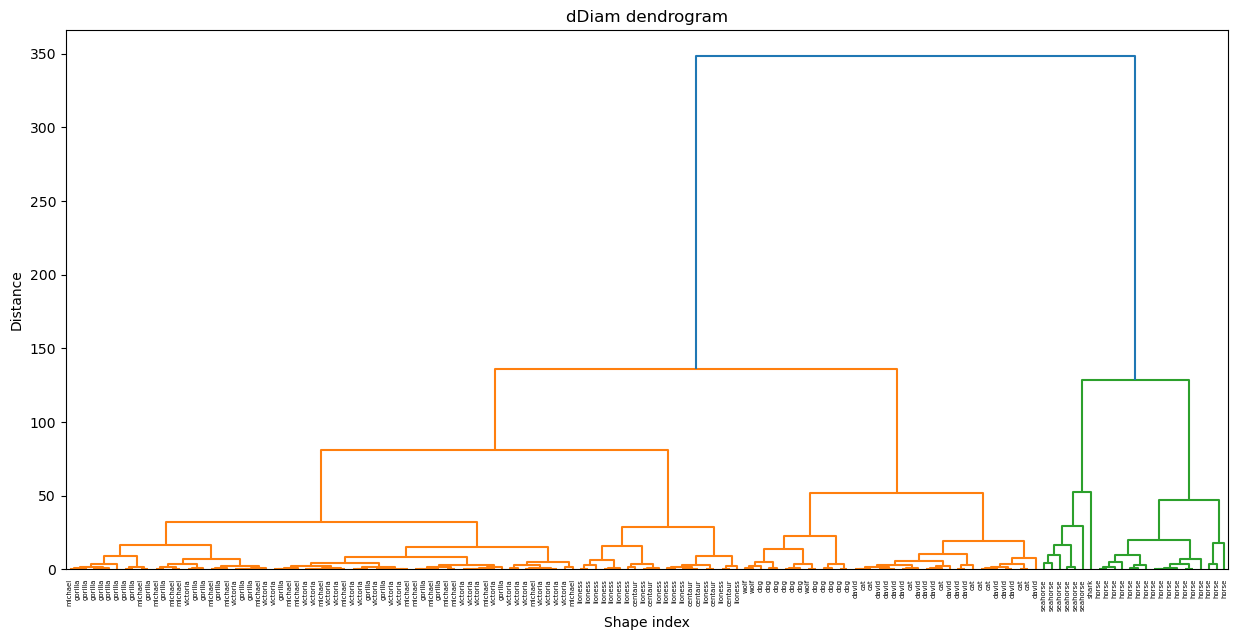

In [26]:
# 1. dendrogram

from scipy.cluster.hierarchy import single, dendrogram
from scipy.spatial.distance import squareform

converted_d_diam_matrix = squareform(dDiam_matrix, checks= False)

linked_d_diam = complete(converted_d_diam_matrix)

plt.figure(0, figsize=(15, 7))
dendrogram(linked_d_diam, orientation='top', distance_sort='descending', show_leaf_counts=False, labels=y_geodesic)
plt.title("dDiam dendrogram")

plt.xlabel("Shape index")
plt.ylabel("Distance")
plt.savefig("dDiam_dendrogram.png")
plt.show()

In [42]:
# 2. k-means with exact K-value (k=12)
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

def evaluate_clustering(distance_matrix, name,y_labels, k=12):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(distance_matrix)
    labels = kmeans.labels_

    y_encoded = LabelEncoder().fit_transform(y_labels)
    sil = silhouette_score(distance_matrix, labels, metric='precomputed')
    rand = adjusted_rand_score(y_encoded, labels)
    print(f"{name} - Silhouette score: {sil}")
    print(f"{name} - Adjusted rand score: {rand}")

    return labels, sil, rand


## Compare Euclidean distance and Geodesic distance

/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/youngmin/mambaforge/envs/tda_newer/lib/python3.11/site-packages/sklearn/cluster/_kme

dDiam - Silhouette score: 0.5989794079656797
dDiam - Adjusted rand score: 0.43632156260542454
d_G_1 - Silhouette score: 0.3867879046416054
d_G_1 - Adjusted rand score: 0.7313297097587836
d_G_inf - Silhouette score: 0.28840358589163356
d_G_inf - Adjusted rand score: 0.7021907305204439
d_E_inf - Silhouette score: 0.23860844748613408
d_E_inf - Adjusted rand score: 0.43603386019569174


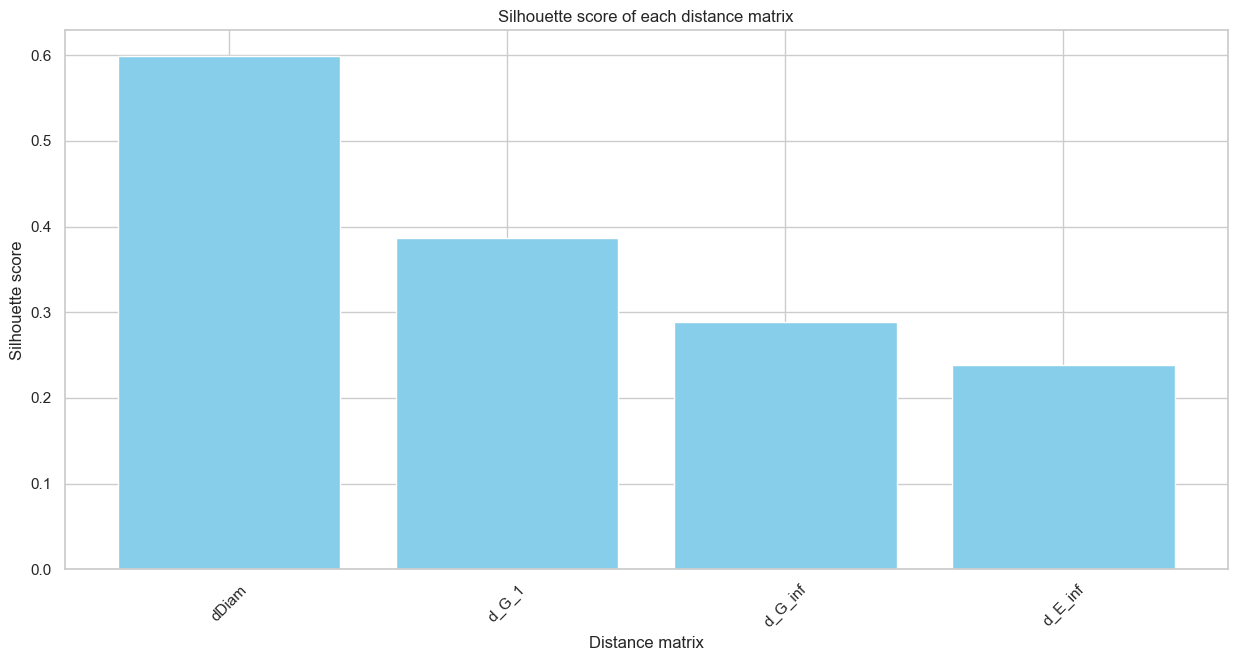

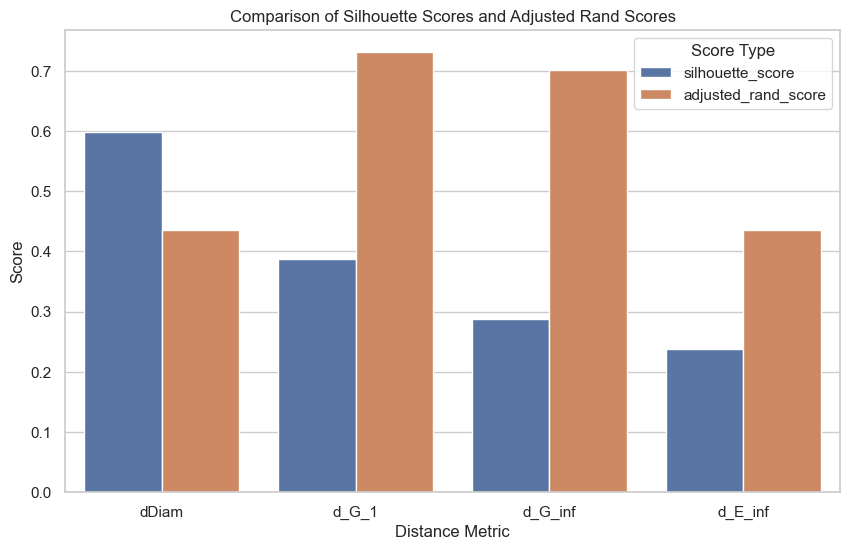

In [45]:

y_geodesic_encoded = LabelEncoder().fit_transform(y_geodesic)
y_euclidean_encoded = LabelEncoder().fit_transform(y_euclidean)

labels_dDiam, sil_diam, rand_diam = evaluate_clustering(dDiam_matrix, "dDiam", y_geodesic, k=12)
labels_d_G_1, sil_d_G_1, rand_d_G_1 = evaluate_clustering(d_G_1_matrix, "d_G_1", y_geodesic, k=12)
labels_d_G_inf, sil_d_G_inf, rand_d_G_inf = evaluate_clustering(d_G_inf_matrix, "d_G_inf", y_geodesic, k=12)
labels_d_E_inf, sil_d_E_inf, rand_d_E_inf = evaluate_clustering(d_E_inf_matrix, "d_E_inf", y_euclidean, k=12)

plt.figure(0, figsize=(15, 7))
# bar plot. sil_diam rand_diam  sil_d_G_1 rand_d_G_1 sil_d_G_inf rand_d_G_inf sil_d_E_inf rand_d_E_inf
plt.bar(["dDiam", "d_G_1", "d_G_inf", "d_E_inf"], [sil_diam, sil_d_G_1, sil_d_G_inf, sil_d_E_inf], color = "skyblue")
plt.xlabel("Distance matrix")
plt.ylabel("Silhouette score")
plt.title("Silhouette score of each distance matrix")
plt.xticks(rotation=45)
plt.show()

cluster_eval_df = pd.DataFrame({"distance_matrix": ["dDiam", "d_G_1", "d_G_inf", "d_E_inf"],
                                "silhouette_score": [sil_diam, sil_d_G_1, sil_d_G_inf, sil_d_E_inf],
                                "adjusted_rand_score": [rand_diam, rand_d_G_1, rand_d_G_inf, rand_d_E_inf]})


# Reshape for plotting
df_melted = cluster_eval_df.melt(id_vars='distance_matrix', var_name='Score_Type', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='distance_matrix', y='Score', hue='Score_Type', data=df_melted)

# Customizing the plot
plt.xlabel('Distance Metric')
plt.ylabel('Score')
plt.title('Comparison of Silhouette Scores and Adjusted Rand Scores')
plt.legend(title='Score Type')

# Show the plot
plt.show()
